We're going to attempt the price prediction for AirBnBs again, but this time we'll employ the use of random forests.

Let's begin by installing the required libraries.

In [1]:
!pip install jovian --upgrade --quiet
!pip install opendatasets scikit-learn plotly folium --upgrade --quiet
!pip install pandas numpy matplotlib seaborn --quiet

In [2]:
import jovian
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import plot_tree, export_text
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from IPython.display import FileLink
from zipfile import ZipFile
from urllib.request import urlretrieve

In [3]:
jovian.commit(project='AirBnb-Random-Forests')

<IPython.core.display.Javascript object>

[jovian] Creating a new project "moaaz645/AirBnb-Random-Forests"


[jovian] Error: Looks like the notebook is missing output cells, please save the notebook and try jovian.commit again.


[jovian] Committed successfully! https://jovian.ai/moaaz645/airbnb-random-forests


'https://jovian.ai/moaaz645/airbnb-random-forests'

## Download and prepare the dataset for training

In [4]:
dataset_url = 'https://github.com/JovianML/opendatasets/raw/master/data/house-prices-advanced-regression-techniques.zip'
urlretrieve(dataset_url, 'house-prices.zip')
with ZipFile('house-prices.zip') as f:
    f.extractall(path='house-prices')
    
os.listdir('house-prices')

['data_description.txt', 'sample_submission.csv', 'test.csv', 'train.csv']

In [5]:
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

prices_df = pd.read_csv('house-prices/train.csv')
prices_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,Gas

In [6]:
# Identify input and target columns
input_cols, target_col = prices_df.columns[1:-1], prices_df.columns[-1]
inputs_df, targets = prices_df[input_cols].copy(), prices_df[target_col].copy()

# Identify numeric and categorical columns
numeric_cols = prices_df[input_cols].select_dtypes(include=np.number).columns.tolist()
categorical_cols = prices_df[input_cols].select_dtypes(include='object').columns.tolist()

# Impute and scale numeric columns
imputer = SimpleImputer().fit(inputs_df[numeric_cols])
inputs_df[numeric_cols] = imputer.transform(inputs_df[numeric_cols])
scaler = MinMaxScaler().fit(inputs_df[numeric_cols])
inputs_df[numeric_cols] = scaler.transform(inputs_df[numeric_cols])

# One-hot encode categorical columns
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(inputs_df[categorical_cols])
encoded_cols = list(encoder.get_feature_names(categorical_cols))
inputs_df[encoded_cols] = encoder.transform(inputs_df[categorical_cols])

# Create training and validation sets
train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    inputs_df[numeric_cols + encoded_cols], targets, test_size=0.25, random_state=42)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


## Decision Tree


In [7]:
# Create the model
tree = DecisionTreeRegressor()

In [8]:
# Fit the model to the training data
tree.fit(train_inputs, train_targets)

DecisionTreeRegressor()

In [9]:
tree_train_preds = tree.predict(train_inputs)

In [10]:
tree_train_rmse = mean_squared_error(tree_train_preds,train_targets,squared=False)

In [11]:
tree_val_preds = tree.predict(val_inputs)

In [12]:
tree_val_rmse = mean_squared_error(tree_val_preds,val_targets,squared=False)

In [13]:
print('Train RMSE: {}\nValidation RMSE: {}'.format(tree_train_rmse, tree_val_rmse))

Train RMSE: 0.0
Validation RMSE: 36427.86376106236


### Visualizing The Tree

In [14]:
sns.set_style('darkgrid')
%matplotlib inline

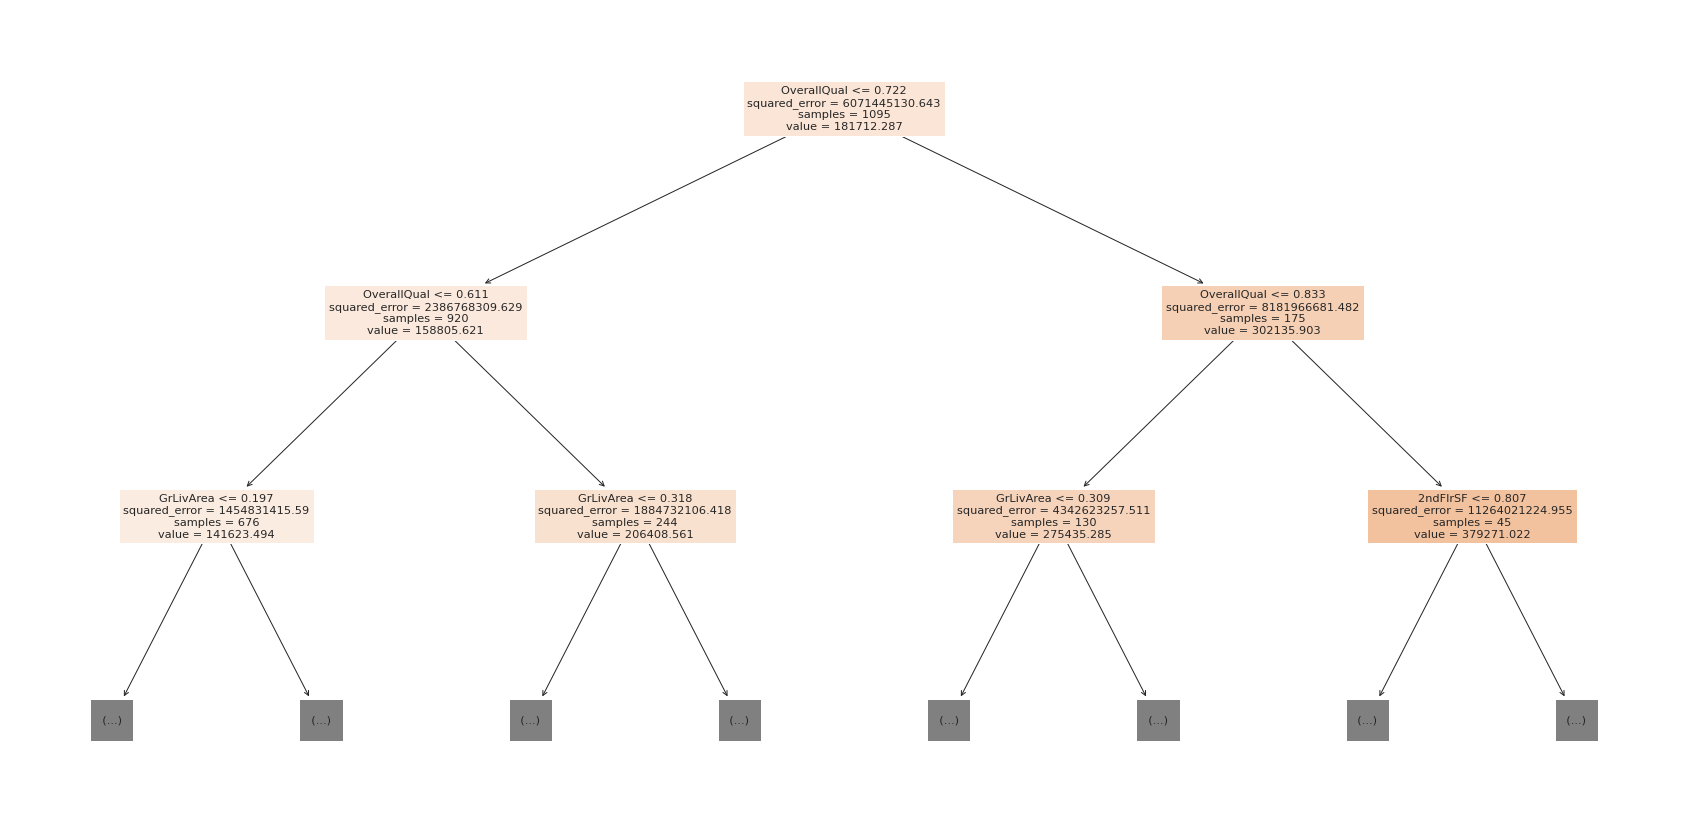

In [15]:
plt.figure(figsize=(30,15))
# Visualize the tree graphically using plot_tree
plot_tree(tree, feature_names=train_inputs.columns, max_depth=2, filled=True);

In [16]:
# Visualize the tree textually using export_text
tree_text = export_text(tree, max_depth=10, feature_names=list(train_inputs.columns))

In [17]:
# Display the first few lines
print(tree_text[:2000])

|--- OverallQual <= 0.72
|   |--- OverallQual <= 0.61
|   |   |--- GrLivArea <= 0.20
|   |   |   |--- TotalBsmtSF <= 0.16
|   |   |   |   |--- OverallQual <= 0.39
|   |   |   |   |   |--- GarageCond_TA <= 0.50
|   |   |   |   |   |   |--- LotArea <= 0.04
|   |   |   |   |   |   |   |--- CentralAir_N <= 0.50
|   |   |   |   |   |   |   |   |--- Functional_Maj2 <= 0.50
|   |   |   |   |   |   |   |   |   |--- Fireplaces <= 0.17
|   |   |   |   |   |   |   |   |   |   |--- LotConfig_Inside <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- LotConfig_Inside >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |   |   |   |--- Fireplaces >  0.17
|   |   |   |   |   |   |   |   |   |   |--- BldgType_Twnhs <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [100000.00]
|   |   |   |   |   |   |   |   |   |   |--- BldgType_Twnhs >  0.50
|   |   |   

In [18]:
# Check feature importance
tree_importances = tree.feature_importances_

In [19]:
tree_importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': tree_importances
}).sort_values('importance', ascending=False)

In [20]:
tree_importance_df

,feature,importance
3,OverallQual,0.632451
15,GrLivArea,0.106725
13,2ndFlrSF,0.032993
11,TotalBsmtSF,0.027212
8,BsmtFinSF1,0.026652
...,...,...
86,Neighborhood_StoneBr,0.000000
85,Neighborhood_Somerst,0.000000
191,BsmtCond_Po,0.000000
193,BsmtCond_nan,0.000000


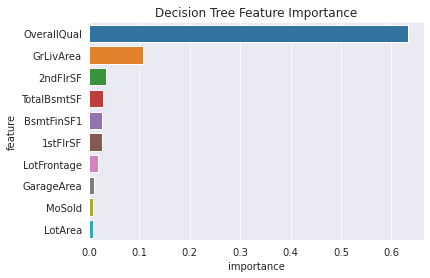

In [21]:
plt.title('Decision Tree Feature Importance')
sns.barplot(data=tree_importance_df.head(10), x='importance', y='feature');

## Random Forests


In [22]:
# Create the model
rf1 = RandomForestRegressor()

In [23]:
# Fit the model
rf1.fit(train_inputs, train_targets)

RandomForestRegressor()

In [24]:
rf1_train_preds = rf1.predict(train_inputs)

In [25]:
rf1_train_rmse = mean_squared_error(rf1_train_preds,train_targets,squared=False)

In [26]:
rf1_val_preds = rf1.predict(val_inputs)

In [27]:
rf1_val_rmse = mean_squared_error(rf1_val_preds,val_targets,squared=False)

In [28]:
print('Train RMSE: {}, Validation RMSE: {}'.format(rf1_train_rmse, rf1_val_rmse))

Train RMSE: 12151.884966430482, Validation RMSE: 27154.351451005285


## Hyperparameter Tuning

Let us now tune the hyperparameters of our model. You can find the hyperparameters for `RandomForestRegressor` here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

Hyperparameters are use

Let's define a helper function `test_params` which can test the given value of one or more hyperparameters.

In [29]:
def test_params(**params):
    model = RandomForestRegressor(random_state=42, n_jobs=-1, **params).fit(train_inputs, train_targets)
    train_rmse = mean_squared_error(model.predict(train_inputs), train_targets, squared=False)
    val_rmse = mean_squared_error(model.predict(val_inputs), val_targets, squared=False)
    return train_rmse, val_rmse

It can be used as follows:

In [30]:
test_params(n_estimators=20, max_depth=20)

(13776.89957127333, 28886.033523273858)

In [31]:
test_params(n_estimators=50, max_depth=10, min_samples_leaf=4, max_features=0.4)

(20490.359632429263, 29804.931642791606)

Let's also define a helper function to test and plot different values of a single parameter.

In [32]:
def test_param_and_plot(param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_rmse, val_rmse = test_params(**params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

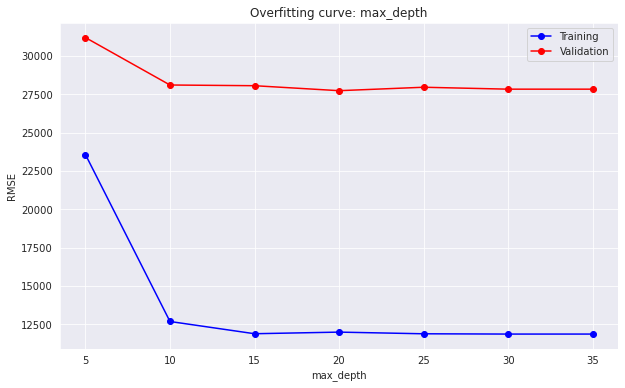

In [33]:
test_param_and_plot('max_depth', [5, 10, 15, 20, 25, 30, 35])

From the above graph, it appears that the best value for `max_depth` is around 20, beyond which the model starts to overfit.

### Experimenting with different variables and finding their optimal values

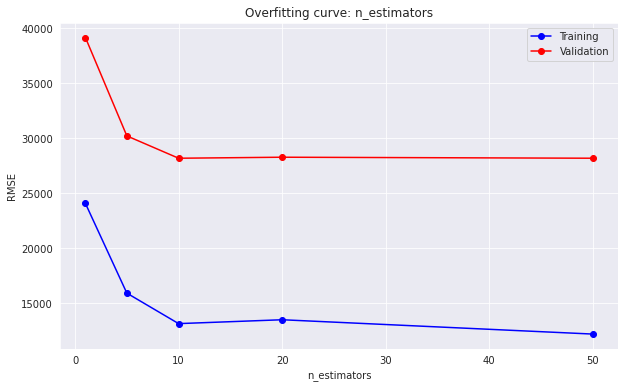

In [34]:
test_param_and_plot('n_estimators', [1,5,10,20,50])
# n_estimators = 10

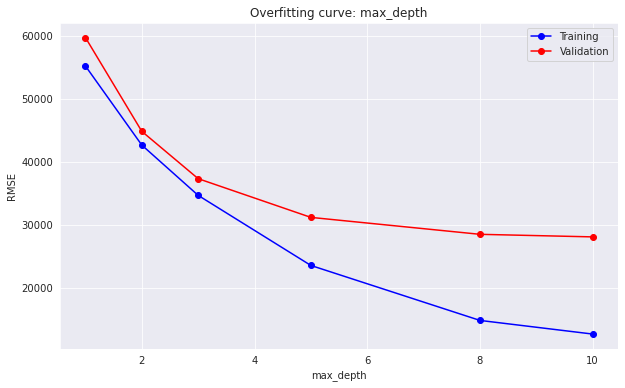

In [35]:
test_param_and_plot('max_depth', [1,2,3,5,8,10])
# max_depth = 10

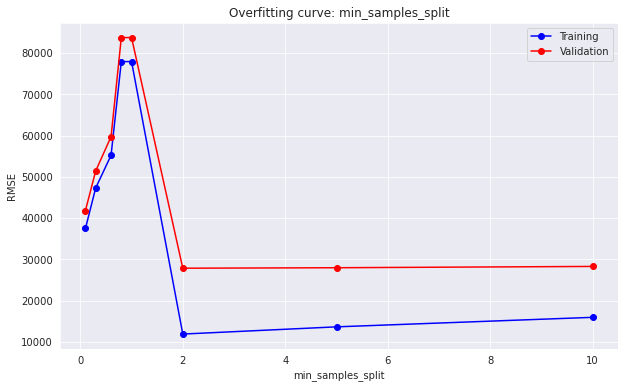

In [36]:
test_param_and_plot('min_samples_split', [0.1,0.3,0.6,0.8,1.0,2,5,10])
# min_samples_split = 2

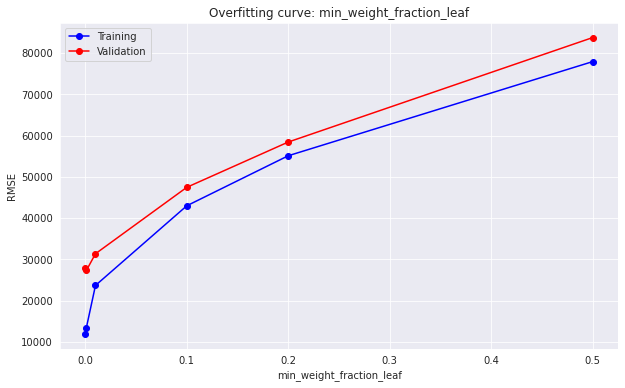

In [37]:
test_param_and_plot('min_weight_fraction_leaf',[0.0001,0.001,0.01,0.1,0.2,0.5])
# min_weight_fraction_leaf = 0.001

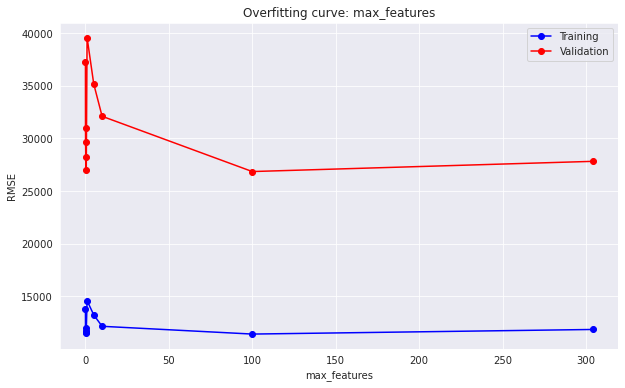

In [38]:
test_param_and_plot('max_features',[0.01,0.05,0.1,0.2,0.5,1,5,10,100,304])
# max_features = 100

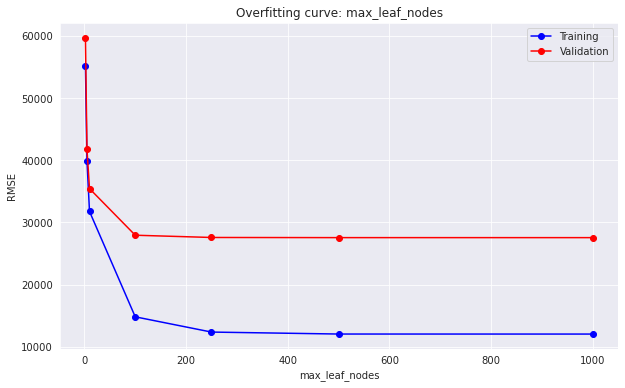

In [39]:
test_param_and_plot('max_leaf_nodes',[2,5,10,100,250,500,1000])
# max_leaf_nodes = 100

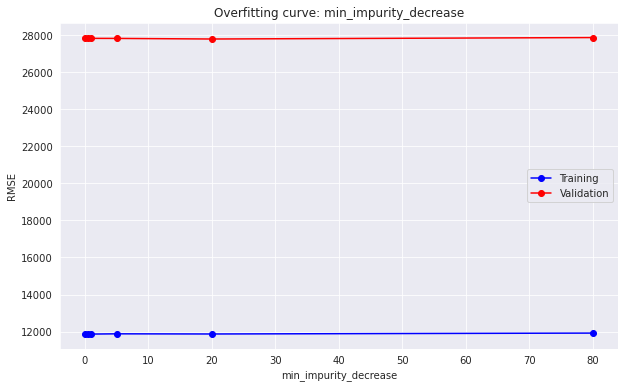

In [40]:
test_param_and_plot('min_impurity_decrease',[0.1,0.5,1,5,20,80])
# min_impurity_decrease = 1/rng (doesn't affect)

## Training the Best Model

In [43]:
# Create the model with custom hyperparameters
rf2 = RandomForestRegressor(n_estimators = 10, max_depth = 10, min_samples_split = 2, min_weight_fraction_leaf = 0.001, max_features = 304, max_leaf_nodes = 100, )

In [44]:
# Train the model
rf2.fit(train_inputs,train_targets)

RandomForestRegressor(max_depth=10, max_features=304, max_leaf_nodes=100,
                      min_weight_fraction_leaf=0.001, n_estimators=10)

### Making Predictions

In [45]:
rf2_train_preds = rf2.predict(train_inputs)

In [46]:
rf2_train_rmse = mean_squared_error(rf2_train_preds,train_targets,squared=False)

In [47]:
rf2_val_preds = rf2.predict(val_inputs)

In [48]:
rf2_val_rmse = mean_squared_error(rf2_val_preds,val_targets,squared=False)

In [49]:
print('Train RMSE: {}, Validation RMSE: {}'.format(rf2_train_rmse, rf2_val_rmse))

Train RMSE: 17797.44979068067, Validation RMSE: 30002.177063416897


Let's also view and plot the feature importances.

In [50]:
rf2_importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': rf2.feature_importances_
}).sort_values('importance', ascending=False)

In [51]:
rf2_importance_df

,feature,importance
3,OverallQual,0.576062
15,GrLivArea,0.115915
12,1stFlrSF,0.030531
25,GarageCars,0.028442
8,BsmtFinSF1,0.027093
...,...,...
154,Exterior2nd_HdBoard,0.000000
155,Exterior2nd_ImStucc,0.000000
64,Neighborhood_Blmngtn,0.000000
157,Exterior2nd_Other,0.000000


<AxesSubplot:xlabel='importance', ylabel='feature'>

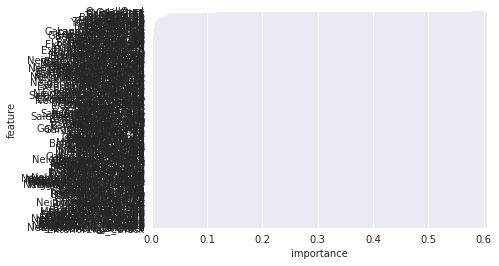

In [52]:
sns.barplot(data=rf2_importance_df, x='importance', y='feature')

## Making Predictions on the Test Set

Let's make predictions on the test set provided with the data.

In [53]:
test_df = pd.read_csv('house-prices/test.csv')

In [54]:
test_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,Comp

First, we need to reapply all the preprocessing steps.

In [55]:
test_df[numeric_cols] = imputer.transform(test_df[numeric_cols])
test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])
test_df[encoded_cols] = encoder.transform(test_df[categorical_cols])

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


In [56]:
test_inputs = test_df[numeric_cols + encoded_cols]

We can now make predictions using our final model.

In [57]:
test_preds = rf2.predict(test_inputs)

In [58]:
predictions_df = pd.read_csv('house-prices/sample_submission.csv')

In [59]:
predictions_df

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659


Let's replace the values of the `SalePrice` column with our predictions.

In [60]:
predictions_df['SalePrice'] = test_preds

Let's save it as a CSV file and download it.

In [61]:
submission_df.to_csv('preds.csv', index=False)

NameError: name 'submission_df' is not defined

In [ ]:
FileLink('submission.csv') # Doesn't work on Colab, use the file browser instead to download the file.

### Making Predictions on Single Inputs

In [ ]:
def predict_input(model, single_input):
    input_df = pd.DataFrame([single_input])
    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols].values)
    return model.predict(input_df[numeric_cols + encoded_cols])[0]

In [ ]:
sample_input = { 'MSSubClass': 20, 'MSZoning': 'RL', 'LotFrontage': 77.0, 'LotArea': 9320,
 'Street': 'Pave', 'Alley': None, 'LotShape': 'IR1', 'LandContour': 'Lvl', 'Utilities': 'AllPub',
 'LotConfig': 'Inside', 'LandSlope': 'Gtl', 'Neighborhood': 'NAmes', 'Condition1': 'Norm', 'Condition2': 'Norm',
 'BldgType': '1Fam', 'HouseStyle': '1Story', 'OverallQual': 4, 'OverallCond': 5, 'YearBuilt': 1959,
 'YearRemodAdd': 1959, 'RoofStyle': 'Gable', 'RoofMatl': 'CompShg', 'Exterior1st': 'Plywood',
 'Exterior2nd': 'Plywood', 'MasVnrType': 'None','MasVnrArea': 0.0,'ExterQual': 'TA','ExterCond': 'TA',
 'Foundation': 'CBlock','BsmtQual': 'TA','BsmtCond': 'TA','BsmtExposure': 'No','BsmtFinType1': 'ALQ',
 'BsmtFinSF1': 569,'BsmtFinType2': 'Unf','BsmtFinSF2': 0,'BsmtUnfSF': 381,
 'TotalBsmtSF': 950,'Heating': 'GasA','HeatingQC': 'Fa','CentralAir': 'Y','Electrical': 'SBrkr', '1stFlrSF': 1225,
 '2ndFlrSF': 0, 'LowQualFinSF': 0, 'GrLivArea': 1225, 'BsmtFullBath': 1, 'BsmtHalfBath': 0, 'FullBath': 1,
 'HalfBath': 1, 'BedroomAbvGr': 3, 'KitchenAbvGr': 1,'KitchenQual': 'TA','TotRmsAbvGrd': 6,'Functional': 'Typ',
 'Fireplaces': 0,'FireplaceQu': np.nan,'GarageType': np.nan,'GarageYrBlt': np.nan,'GarageFinish': np.nan,'GarageCars': 0,
 'GarageArea': 0,'GarageQual': np.nan,'GarageCond': np.nan,'PavedDrive': 'Y', 'WoodDeckSF': 352, 'OpenPorchSF': 0,
 'EnclosedPorch': 0,'3SsnPorch': 0, 'ScreenPorch': 0, 'PoolArea': 0, 'PoolQC': np.nan, 'Fence': np.nan, 'MiscFeature': 'Shed',
 'MiscVal': 400, 'MoSold': 1, 'YrSold': 2010, 'SaleType': 'WD', 'SaleCondition': 'Normal'}

In [ ]:
predicted_price = predict_input(rf2, sample_input)

In [ ]:
print('The predicted sale price of the house is ${}'.format(predicted_price))

### Saving the Model

In [ ]:
import joblib

In [ ]:
house_prices_rf = {
    'model': rf2,
    'imputer': imputer,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

In [ ]:
joblib.dump(house_prices_rf, 'house_prices_rf.joblib')

In [ ]:
jovian.commit(outputs=['house_prices_rf.joblib'])